[*********************100%***********************]  1 of 1 completed


Epoch [10/100], Loss: 0.0242
Epoch [20/100], Loss: 0.0178
Epoch [30/100], Loss: 0.0161
Epoch [40/100], Loss: 0.0111
Epoch [50/100], Loss: 0.0018
Epoch [60/100], Loss: 0.0012
Epoch [70/100], Loss: 0.0009
Epoch [80/100], Loss: 0.0006
Epoch [90/100], Loss: 0.0005
Epoch [100/100], Loss: 0.0004


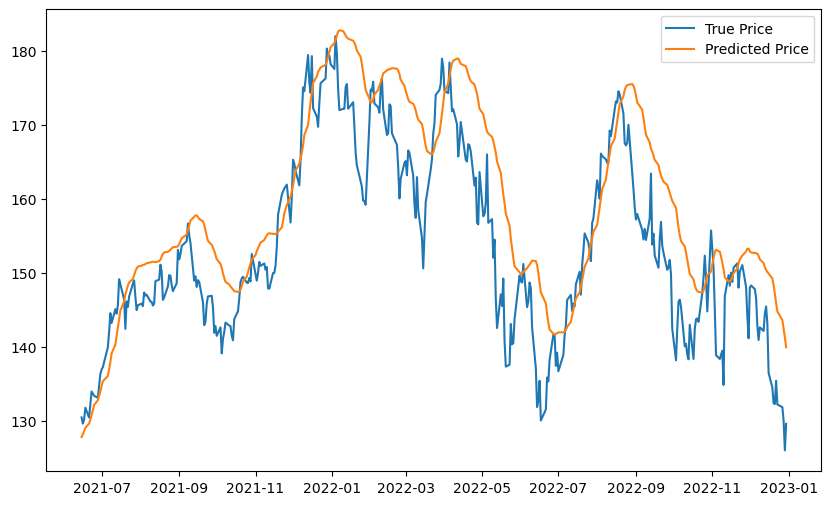

In [6]:
# 它使用了PyTorch和LSTM（长短期记忆网络）来预测股票价格的走势，并生成交易信号
import torch
import torch.nn as nn
import numpy as np
import yfinance as yf  # 用于获取历史股票数据
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# 获取历史股票数据
def get_stock_data(stock_symbol, start_date, end_date):
    df = yf.download(stock_symbol, start=start_date, end=end_date)
    return df

# 定义LSTM模型
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # 取LSTM最后一个时间步的输出
        return out

# 生成训练数据
def create_dataset(data, time_step=60):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# 设置参数
stock_symbol = 'AAPL'  # 苹果公司的股票数据
start_date = '2015-01-01'
end_date = '2023-01-01'
time_step = 60       # 调整时间步长
train_ratio = 0.8
input_size = 1
hidden_size = 64      # 调大hidden_size
num_layers = 2        # 增加LSTM层数
output_size = 1
num_epochs = 100      # 增加训练轮数
learning_rate = 0.001 # 调整学习率

# 获取并预处理数据
df = get_stock_data(stock_symbol, start_date, end_date)
df_close = df[['Close']]  # 使用收盘价
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_close)

X, y = create_dataset(scaled_data, time_step)
X = X.reshape(X.shape[0], X.shape[1], 1)

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_ratio, shuffle=False)

# 转换为PyTorch张量
X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train).view(-1, 1)  # 修改这里
X_test = torch.Tensor(X_test)
y_test = torch.Tensor(y_test).view(-1, 1)  # 修改这里

# 定义模型、损失函数和优化器
model = LSTMModel(input_size, hidden_size, num_layers, output_size)
criterion = nn.SmoothL1Loss()  # 使用Huber损失函数
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

# 训练模型
for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train)
    optimizer.zero_grad()
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# 预测
model.eval()
train_predict = model(X_test)
train_predict = train_predict.detach().numpy()

# 还原预测值和真实值
train_predict = scaler.inverse_transform(train_predict)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# 绘制结果
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(df.index[-len(y_test):], y_test, label='True Price')
plt.plot(df.index[-len(y_test):], train_predict, label='Predicted Price')
plt.legend()
plt.show()